In [45]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn.ensemble import ExtraTreesClassifier
import joblib

from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score

import seaborn as sns
from matplotlib import pyplot as plt

In [46]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading pretrained models**

In [47]:
# Load deep learning model
# deep_learning_model = load_model('deep_learning_model.h5')

# Load XGBoost classifier
xgboost_class = joblib.load('/content/drive/My Drive/ms_wind_curtailment_prediction/xgboost_class.pkl')

# Load Extra Trees classifier
extra_trees_clf = joblib.load('/content/drive/My Drive/ms_wind_curtailment_prediction/extra_trees_classifier.pkl')

In [48]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [49]:
df.index = pd.to_datetime(df.index)
df.drop(['wind_speed_m/s', 'wind_speed_m/s_lag1', 'wind_speed_m/s_lag2', 'wind_speed_m/s_lag3'], inplace=True, axis=1)

In [50]:
# select train datset
start_date_train = '2021-07-01'
end_date_train = '2023-06-30'
df_model_train = df.loc[start_date_train:end_date_train]

start_date_pred = '2023-07-01'
end_date_pred = '2023-12-31'
df_model_pred = df.loc[start_date_pred:end_date_pred]

In [51]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X_train = df_model_train.drop(['redispatch', 'level'], axis = 1)
X_test = df_model_pred.drop(['redispatch', 'level'], axis = 1)
y_train = df_model_train['redispatch']
y_test = df_model_pred['redispatch']

Voting use a soft vote

In [42]:
# Create a voting classifier with soft voting
voting_classifier = VotingClassifier(
    estimators=[
        ('xgboost', xgboost_class),
        ('extra_trees', extra_trees_clf)
    ],
    voting='soft'
)

# preprocess train and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# fit the model
voting_classifier.fit(X_train_preprocessed, y_train_preprocessed)

# Make predictions using the voting classifier
threshold = 0.72
y_prob_voting = voting_classifier.predict_proba(X_test_preprocessed)
y_pred_voting = (y_prob_voting[:, 1] >= threshold).astype(int)
y_train_prob_voting = voting_classifier.predict_proba(X_train_preprocessed)
y_pred_train_voting = (y_train_prob_voting[:, 1] >= threshold).astype(int)

# evaluate
precision_score_test = precision_score(y_test, y_pred_voting)
f1_score_test = f1_score(y_test, y_pred_voting)
conf_matrix_test = confusion_matrix(y_test, y_pred_voting)

precision_train_score = precision_score(y_train_preprocessed, y_pred_train_voting)
f1_train_score = f1_score(y_train_preprocessed, y_pred_train_voting)
conf_train_matrix = confusion_matrix(y_train_preprocessed, y_pred_train_voting)

# print evaluation
print("Scores:")
print("Precision:", precision_score_test)
print("F1-Scores:", f1_score_test)
print("Average Confusion Matrix:")
print(f"{'True Negative':<20} {'False Positive':<20}")
print(f"{conf_matrix_test[0][0]:<20} {conf_matrix_test[0][1]:<20}")
print(f"{'False Negative':<20} {'True Positive':<20}")
print(f"{conf_matrix_test[1][0]:<20} {conf_matrix_test[1][1]:<20}")

print("Precision (Train):", precision_train_score)
print("F1-Scores (Train):", f1_train_score)
print("Average Confusion Matrix (Train):")
print(f"{'True Negative':<20} {'False Positive':<20}")
print(f"{conf_train_matrix[0][0]:<20} {conf_train_matrix[0][1]:<20}")
print(f"{'False Negative':<20} {'True Positive':<20}")
print(f"{conf_train_matrix[1][0]:<20} {conf_train_matrix[1][1]:<20}")

Scores:
Precision: 0.29574132492113564
F1-Scores: 0.3273679615888258
Average Confusion Matrix:
True Negative        False Positive      
15664                893                 
False Negative       True Positive       
648                  375                 
Precision (Train): 0.8523629084149568
F1-Scores (Train): 0.3103838794079744
Average Confusion Matrix (Train):
True Negative        False Positive      
60769                2065                
False Negative       True Positive       
50912                11922               


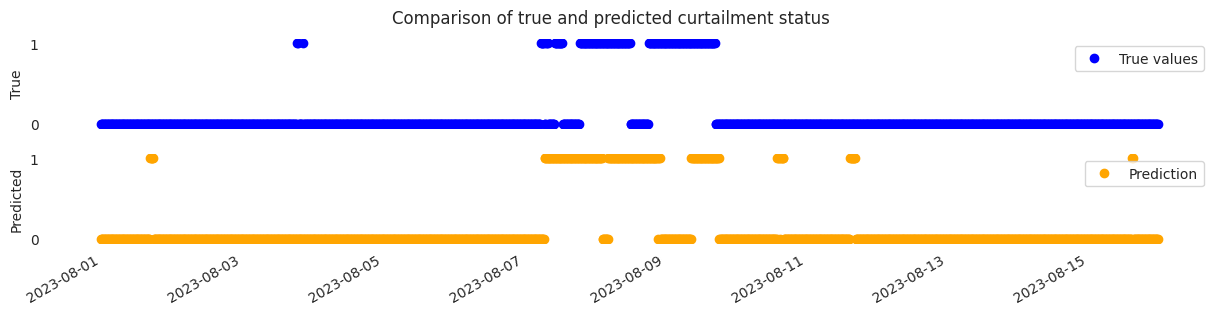

In [73]:
sns.set_style("whitegrid")
#df_model_pred['y_pred_voting'] = y_pred_voting
#df_model_pred = df_model_pred.loc['2023-08-01':'2023-08-15']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 3), sharex=True)
ax1.plot(df_model_pred.index, df_model_pred['redispatch'], marker='o', linestyle='', label='True values', color='blue')
ax1.set_ylabel('True')
ax1.legend()

ax2.plot(df_model_pred.index, df_model_pred['y_pred_voting'], marker='o', linestyle='', label='Prediction', color='orange')
ax2.set_ylabel('Predicted')
ax2.legend()
plt.gcf().autofmt_xdate()
plt.suptitle('Comparison of true and predicted curtailment status')

ax1.grid(False)
ax2.grid(False)
fig.subplots_adjust(hspace=0.3)

plt.gcf().autofmt_xdate()
for ax in [ax1, ax2]:
    ax.locator_params(axis='y', nbins=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

#plt.savefig('redispatch_week.png')
